# Analyzing STAC Metadata from the EO-MQS

This notebook gives you a few examples how you can use tools like `pandas` to make analyses on the queried metadata.

In [1]:
import pandas as pd
import geopandas
from pystac_client import Client
import requests
import matplotlib.pyplot as plt

client = Client.open("https://mqs.eodc.eu/stac/v1")

## Load Sentinel-2 Items for November 2022

In [2]:
time_period = "2022-11-01/2022-11-30"
limit = 100

In [3]:
s2_collections = []
for collection in client.get_collections():
    if "l1c" in collection.id.lower() :
        print(f"Append collection {collection.id} to list of Sentinel-2 L1C collections.")
        s2_collections.append(collection.id)


Append collection EODC|sentinel-2-l1c to list of Sentinel-2 L1C collections.
Append collection GRNET-OPENSTACK|sentinel-2-l1c to list of Sentinel-2 L1C collections.
Append collection CollGS_CZ|sentinel-2-l1c to list of Sentinel-2 L1C collections.
Append collection VITO|urn:eop:VITO:CGS_S2_L1C to list of Sentinel-2 L1C collections.


In [4]:
def get_search(collection: str, bbox = None) -> geopandas.geodataframe.GeoDataFrame:
    gpd = None
    try:
        results = client.search(collections=[collection], 
                            datetime=time_period, 
                            bbox=bbox,
                            limit=limit,
                            method="GET")
        _gpd = geopandas.GeoDataFrame.from_features(results.item_collection())
    except:
        print(f"Search for items with collection id {collection} failed or no items found.")
    else:
        gpd = _gpd
    return gpd        

def get_cloud_cover_ts(gdf: geopandas.geodataframe.GeoDataFrame) -> pd.core.series.Series:
    ts = None
    try:
        gdf["datetime"] = pd.to_datetime(gdf["datetime"])
        _ts = gdf.set_index("datetime").sort_index()["eo:cloud_cover"]
    except KeyError:
        print("eo:cloud_cover not available")
    else:
        ts = _ts 
    return ts


In [5]:
df_eodc = get_search("EODC|sentinel-2-l1c")

In [6]:
ts_eodc = get_cloud_cover_ts(df_eodc)

In [7]:
df_grnet = get_search("GRNET-OPENSTACK|sentinel-2-l1c")

Search for items with collection id GRNET-OPENSTACK|sentinel-2-l1c failed or no items found.


In [8]:
df_cesnet = get_search("CollGS_CZ|sentinel-2-l1c")

In [9]:
ts_cesnet = get_cloud_cover_ts(df_cesnet)

In [10]:
df_vito = get_search("VITO|urn:eop:VITO:CGS_S2_L1C")

In [11]:
ts_vito = get_cloud_cover_ts(df_vito)

eo:cloud_cover not available


<Axes: title={'center': 'S2 Cloud Cover - EU Region October 2022 (CollGS_CZ|sentinel-2-l1c)'}, xlabel='datetime', ylabel='eo:cloud-cover [%]'>

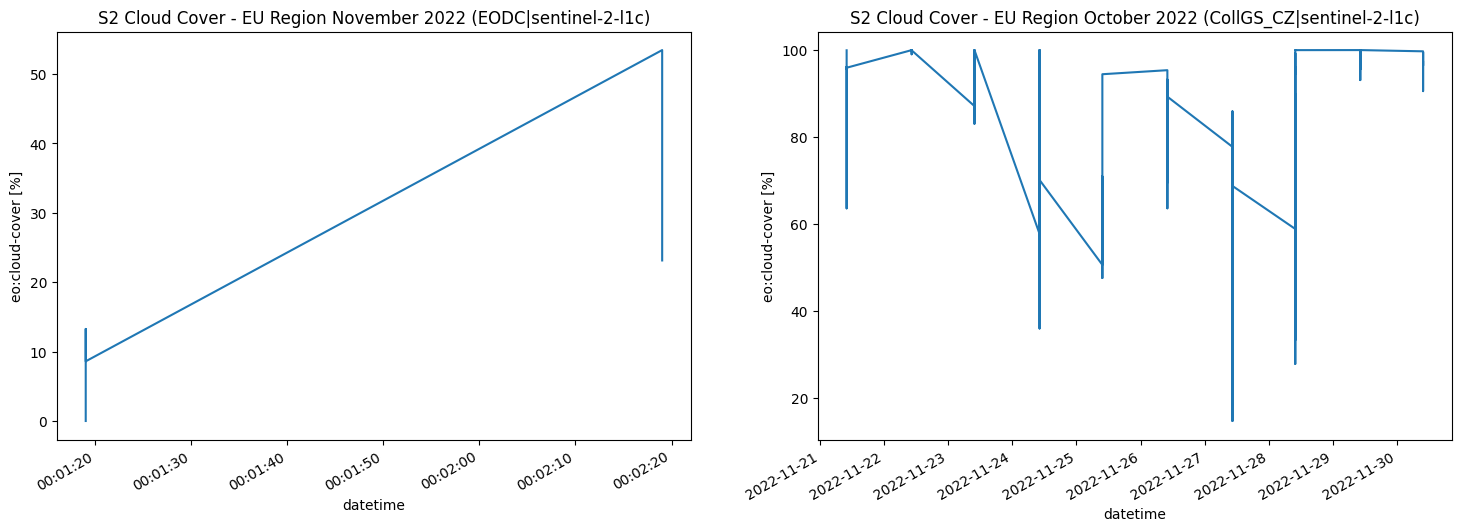

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
ts_eodc.plot(ax=axes[0],
             kind='line',
             ylabel='eo:cloud-cover [%]',
             title='S2 Cloud Cover - EU Region November 2022 (EODC|sentinel-2-l1c)')
ts_cesnet.plot(ax=axes[1],
             ylabel='eo:cloud-cover [%]',
             title='S2 Cloud Cover - EU Region October 2022 (CollGS_CZ|sentinel-2-l1c)')


In [13]:
print(f"Collection EODC|sentinel-2-l1c has an average cloud coverage of {ts_eodc.mean()}% in November 2022, CollGS_CZ|sentinel-2-l1c {ts_cesnet.mean()}%.")

Collection EODC|sentinel-2-l1c has an average cloud coverage of 13.353287551758722% in November 2022, CollGS_CZ|sentinel-2-l1c 84.1498664186356%.


## Visualize Sentinel-1 data over EU

In [14]:
aoi_eu_wgs84 = geopandas.read_file("../data/eu_wgs84.geojson")

In [15]:
# Get bbox coordinates to accelerate serach
bbox_eu = aoi_eu_wgs84.bounds.values.tolist()[0]
bbox_eu

[-63.151187329826996,
 -21.349632697207902,
 55.834818182891276,
 70.09213659004354]

In [16]:
time_period = "2022-01-01/.."
limit = 100

In [17]:
df_eodc = get_search("EODC|sentinel1-grd", bbox=bbox_eu)
df_cesnet = get_search("CollGS_CZ|sentinel-1-grd", bbox=bbox_eu)
df_vito = get_search("urn:eop:VITO:CGS_S1_GRD_L1", bbox=bbox_eu)

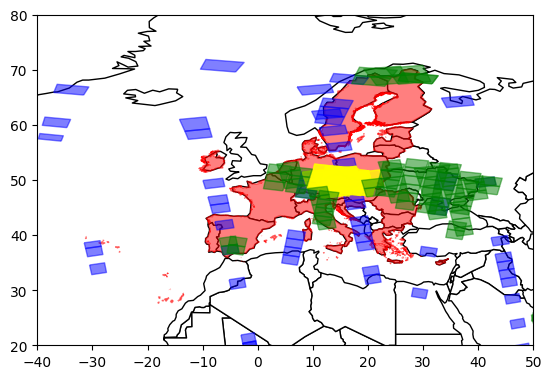

In [18]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black')
aoi_eu_wgs84.plot(ax=ax, edgecolor='red', facecolor="red", alpha=0.5, linewidth=1)
df_eodc.plot(ax=ax, edgecolor='blue', facecolor="blue", alpha=0.5, linewidth=1)
df_cesnet.plot(ax=ax, edgecolor='yellow', facecolor="yellow", alpha=0.5, linewidth=1)
df_vito.plot(ax=ax, edgecolor='green', facecolor="green", alpha=0.5, linewidth=1)
ax.set_xlim([-40,50])
ax.set_ylim([20,80])
plt.show()